# This file is for demonstrating result of the best practice we proposed for the paper on the PLCO Ovarian Cancer dataset obtained from the NIH

For reproducibility we set all random state parameter in the models to be 42. 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from scipy.stats import uniform, randint
import shap
import warnings
from xgboost.sklearn import XGBRegressor
import pickle


warnings.filterwarnings('ignore')

## Problem Formulation

1. OC prediction is a classification problem. Therefore, the end goal is to build a classifier
    * Model we use can be diversed, but according to previous medical literature, we mainly focus on **logistic regression**, **decision tree**, and **random forest**. 
    * For validation, we use **KFold** cross-validation during training
2. Definition of evaluation metric:
    * Predictive ability: which score to use. Following most literature, we use **ROC-AUC**. 
    * Explainability: how to explain to medical experts. We choose **SHAP** with **visualisation**. 

**Decision explanation**: 
1. Choice of model: 
    * Following literature, we acknowledge that with CA-125 and HE4 yielded good results with ROMA, a roughly linear model (except for the pre or post-menopausal part). Thus, we try logistic regression. 
    * Following experience from ML, decision-tree-like models, such as random forest, gradient boosting machine, works great with tabular data. Thus, we try decision tree and random forest. 
2. Choice of ROC-AUC: Following convention of minimising false-positive rate and false-negative rate in this kind of prediction, we choose roc-auc, which is also straightforward when visualised, as our metric. 

---------------------------------------------------------------------------------------------------------------

## Data Collection Demonstration

While this part has already been done by the medical experts, we use the PLCO dataset as an example to demonstrate the good practice captured by their effort. This includes: <br>
* Naming convention
* Data profile (attribute description)

In [5]:
PLCO_OC = pd.read_csv("./PLCO.csv")
columns = [c for c in PLCO_OC.columns if c.startswith("panel") or c.startswith("is")]
DATA = PLCO_OC[columns]

---------------------------------------------------------------------------------------------------------------

## Data Pre-processing

### Imputation/Missing value removal

For safety of not introducing random noise into our dataset (especially when dataset is highly sensitive, such as our medical dataset here), we choose to remove the instances with missing value in **any** of their attributes instead of using an unvarified imputation method. 

In [6]:
DATA = DATA.dropna()
X, Y = DATA.drop(["is_case"], axis=1), DATA["is_case"]

### Train Test Split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Dimension Reduction
We choose to use feature selection methods to reduce the data dimensionality instead of feature extractions due to their explainability. **NOTE: Use ONLY training set for dimension reduction!**

In [16]:
# Remove correlated data
threshold = 0.9

corr_matrix = X_train.corr()
corr_features = set()
for col_ind in range(len(corr_matrix.columns)):
    for row_ind in range(col_ind):
        if abs(corr_matrix.iloc[col_ind, row_ind]) > threshold:
            print(col_ind, row_ind)
#             col_name = corr_matrix.columns[col_ind]
            row_name = corr_matrix.columns[row_ind]
#             corr_features.add(col_name)
            corr_features.add(row_name)
remain_features = [f for f in X.columns if f not in corr_features]
X_train.drop(labels=corr_features, axis=1, inplace=True)

In [17]:
print(corr_features)

set()


## Random Forest and select top 20 features

In [18]:
rf_selector = RandomForestClassifier(random_state=42, n_estimators=200)
rf_selector.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [19]:
FI = dict(zip(X_train.columns, rf_selector.feature_importances_))
FI = dict(sorted(FI.items(), key=lambda item: item[1], reverse=True))
FI

{'panelb_ca125': 0.09000792625556091,
 'panelc_ca125': 0.059516601261380725,
 'panelc_ca125_log': 0.05784835406887971,
 'panelc_he4_log': 0.048560318550356876,
 'panelb_he4': 0.04627290416397493,
 'panelc_he4': 0.04151902656814379,
 'panela_mif': 0.033942344396734575,
 'panela_ca_125': 0.03153429867443332,
 'panelb_ca15_3': 0.030122509796993255,
 'paneld_trf': 0.02970756498243661,
 'panele_mmp_3': 0.026840516756109704,
 'paneld_ctap': 0.025529241882281135,
 'panelc_slpi_log': 0.025398835505235442,
 'paneld_b2m': 0.023112936056508115,
 'panelb_klk6': 0.02147686549940904,
 'panela_igf_ii': 0.019922730843476292,
 'panelb_ca72_4': 0.01974864760776139,
 'panelb_ov_110': 0.01948956371048209,
 'panela_leptin': 0.01940075358519788,
 'panele_eotaxin': 0.01881297982610878,
 'panelc_mesothelin_log': 0.018429646007235793,
 'paneld_apo': 0.01840041167573032,
 'panele_ca72_4': 0.017597652550634987,
 'panele_prolactin': 0.017469606544399333,
 'panelc_spondin2': 0.017347701316110214,
 'panele_he4': 0.

In [20]:
top20 = list(FI.keys())[:20]
top20

['panelb_ca125',
 'panelc_ca125',
 'panelc_ca125_log',
 'panelc_he4_log',
 'panelb_he4',
 'panelc_he4',
 'panela_mif',
 'panela_ca_125',
 'panelb_ca15_3',
 'paneld_trf',
 'panele_mmp_3',
 'paneld_ctap',
 'panelc_slpi_log',
 'paneld_b2m',
 'panelb_klk6',
 'panela_igf_ii',
 'panelb_ca72_4',
 'panelb_ov_110',
 'panela_leptin',
 'panele_eotaxin']

In [21]:
X_train = X_train[top20]

--------------------------------------------------------------------------------------------------------

## Model Fitting

### Logistic Regression
#### Training & Validation

In [22]:
lr_clf = LogisticRegression(random_state=42, max_iter=10000)

In [23]:
lr_clf.fit(X_train, Y_train)

LogisticRegression(max_iter=10000, random_state=42)

#### Testing
First reduce the dimensionality using the assay established on the training set

In [24]:
X_test.drop(labels=corr_features, axis=1, inplace=True)
X_test = X_test[top20]

Then predict and evaluate

ROC-AUC: 0.6176767676767677


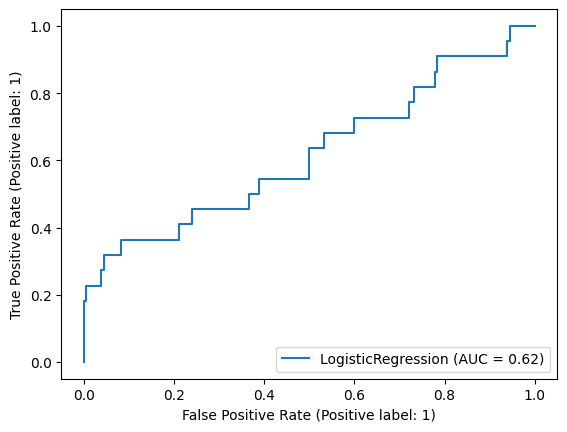

In [27]:
Y_pred_lr = lr_clf.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(Y_test, Y_pred_lr))
RocCurveDisplay.from_estimator(lr_clf, X_test, Y_test)
# plt.savefig("./roc_auc_curve_example.png")
# plt.savefig("./lrresult.png")
plt.show()

In [28]:
# Save the model
# pickle.dump(lr_clf, open("best_lr.skl", 'wb'))

---------------------------------------------------------------------------------------------------------------

### Decision Tree
#### Training & Validation

In [29]:
dt = DecisionTreeClassifier(random_state=42)
dist = {"max_depth": randint(5, 20)}
dt_clf = RandomizedSearchCV(dt, dist, random_state=42, scoring="roc_auc", n_iter=50)
dt_clf.fit(X_train, Y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xffff42e67580>},
                   random_state=42, scoring='roc_auc')

#### Testing

ROC-AUC: 0.5786616161616162


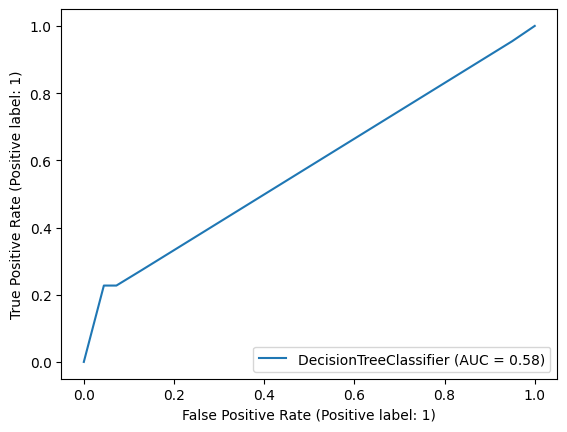

In [30]:
Y_pred_dt = dt_clf.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(Y_test, Y_pred_dt))
best_dt = dt_clf.best_estimator_
RocCurveDisplay.from_estimator(best_dt, X_test, Y_test)
# plt.savefig("./dtresult.png")
plt.show()

In [31]:
# Save the model
# pickle.dump(best_dt, open("best_dt.skl", 'wb'))

---------------------------------------------------------------------------------------------------------------

### RF
#### Training & Validation

In [32]:
rf = RandomForestClassifier(random_state=42)
dist = {"n_estimators": randint(60, 200), "max_depth": randint(2, 20)}

rf_clf = RandomizedSearchCV(rf, dist, random_state=42, scoring="roc_auc", n_iter=50)
rf_clf.fit(X_train, Y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xffff42d5a5f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xffff42cf2530>},
                   random_state=42, scoring='roc_auc')

In [33]:
rf_clf.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=148, random_state=42)

ROC-AUC: 0.622979797979798


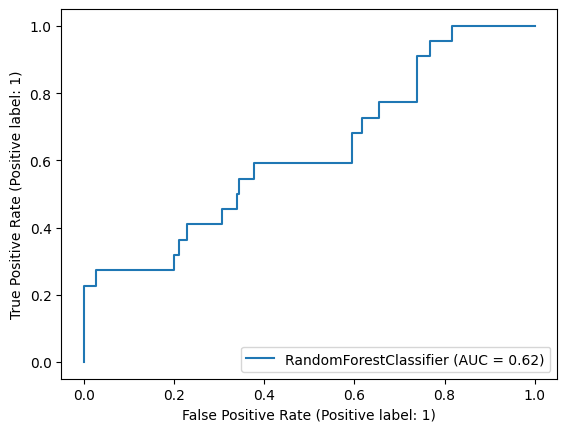

In [34]:
Y_pred_rf = rf_clf.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(Y_test, Y_pred_rf))
best_rf = rf_clf.best_estimator_
RocCurveDisplay.from_estimator(best_rf, X_test, Y_test)
# plt.savefig("./rfresult.png")
plt.show()

In [36]:
rf2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=147,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

rf2.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=147,
                       random_state=42)

ROC-AUC: 0.595959595959596


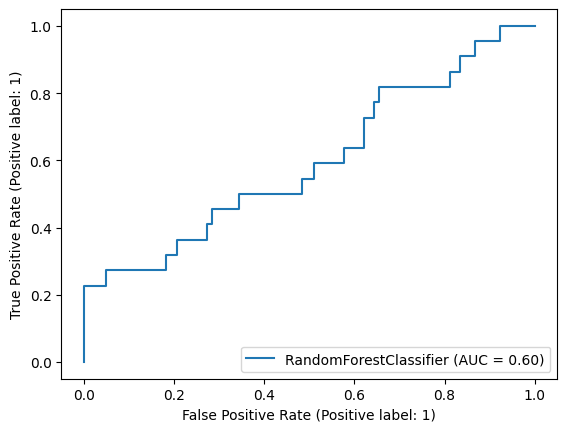

In [37]:
Y_pred_rf2 = rf2.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(Y_test, Y_pred_rf2))
# best_rf2 = rf_clf2.best_estimator_
RocCurveDisplay.from_estimator(rf2, X_test, Y_test)
# plt.savefig("./rfresult.png")
plt.show()

In [38]:
# Save the model
# pickle.dump(best_rf, open("best_rf.skl", 'wb'))

We can see using RandomForest classifier we could get the highest testing score among all three models. To achieve a better predictive ability, we would naturally prefer the RF model. However, RF is also the most complex one, which is generally not explainable. Thus, we proceed to the next step of using Shapley value for the analysis of our RF model. <br>

Another perspective to look at these three results is logistic regression produced results not that bad compared to random forest, but it also possess inherent explainability. So, it is worth discussing how much performance matters against explainabiilty. 

---------------------------------------------------------------------------------------------------------------

## Result Analysis

### Shapley Value for RandomForest
We only try to explain RF using Shapley value since the other two models are inherently explainable. 

In [39]:
rf_explainer = shap.Explainer(best_rf)
rf_shap_values = rf_explainer(X_train)[:, :, 0]

Text(0, 0.5, 'Variable value')

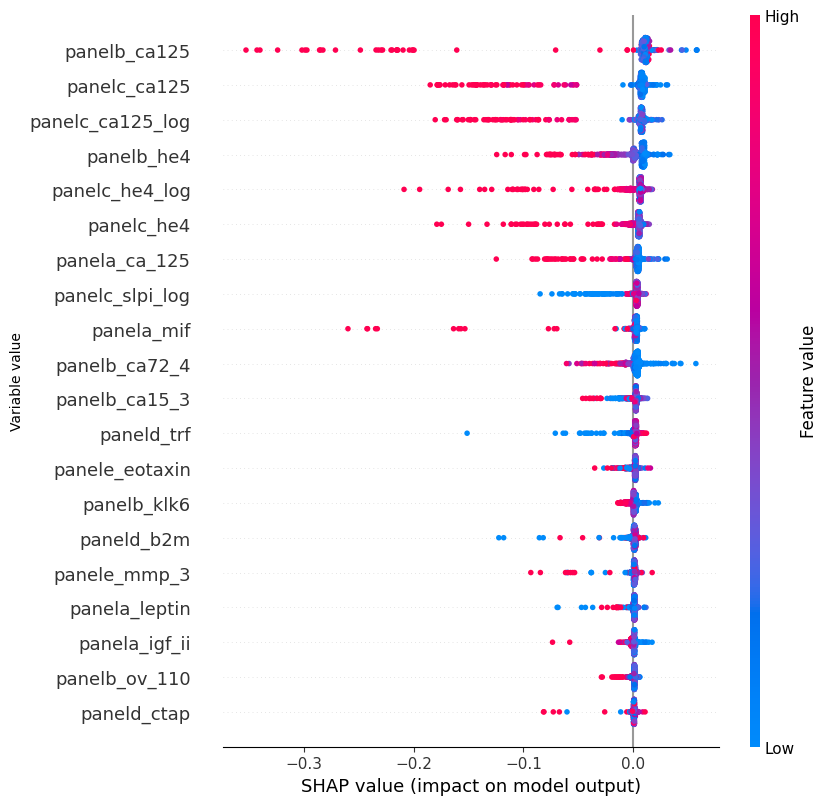

In [40]:
shap.plots.beeswarm(rf_shap_values, max_display=100, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel("Variable value")

# plt.savefig("./globalshap.png")

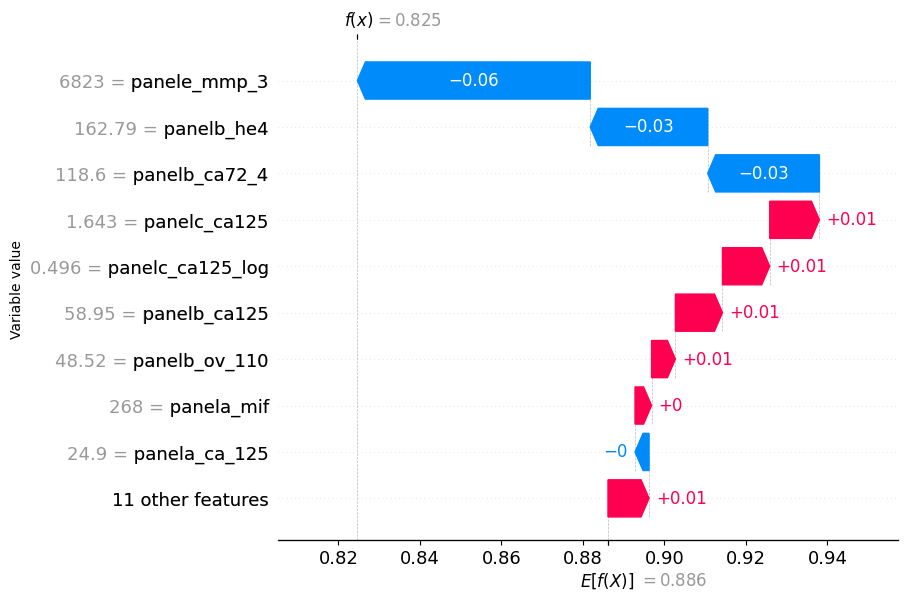

In [45]:
shap.plots.waterfall(rf_shap_values[0], max_display=10, show=True)
fig, ax = plt.gcf(), plt.gca()
# xlim = 0.01
# ax.set_xlim(-xlim, xlim)
# ax.set_title(ax_title, fontdict={"size":font_size})
# plt.savefig("./localshap1.png")